# Setup

In [1]:
import numpy as np
import pickle

from cobaya.run import run
from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

%matplotlib inline

gdplot = gdplt.get_subplot_plotter(width_inch=15)

In [2]:
#jobFile = '/scratch/users/stevensonb/results/DALI_ng.pkl'
jobFile = './dali_bbn.pkl'
experiment = 0
spectrum = 'unlensed'
priorWidth = 5
useDali = True

fixedParams = {} # use {k:v}, values not found in fid will be ignored
removeParams = [] #['N_eff', 'mnu']

## Functions

In [3]:
latex_trans = {
    'omega_c_h2':r'\Omega_\mathrm{cdm}h^2', 
    'omega_b_h2':r'\Omega_\mathrm{b}h^2', 
    'N_eff':r'N_\mathrm{eff}',
    'N_nu':r'N_\mathrm{nu}', 
    'A_s':r'A_\mathrm{s}', 
    'n_s':r'n_\mathrm{s}', 
    'theta_s':r'\theta_\mathrm{s}',
    'tau':r'\tau',
    'mnu':r'm_\mathrm{\nu}',
    'eta10':r'\eta_\mathrm{10}'
}

def get_data(file=jobFile, fixed_params=fixedParams, remove_params=removeParams, experiment=experiment, spectrum=spectrum, prior_width=priorWidth):
    params = {}
    with open(file, 'rb') as f:
        data = pickle.load(f)

    fid = data['cosmoFid']
    fisher = data['fisherGaussian'][experiment][spectrum]
    
    if remove_params:
        for k in remove_params:
            i = list(fid.keys()).index(k)
            fid.pop(k)
            fisher = np.delete(np.delete(fisher, i, 0), i, 1)

    inv = np.linalg.inv(fisher)
    errors = np.sqrt(np.diag(inv))
    widths = prior_width * errors

    for i, (k, v) in enumerate(fid.items()):
        if k not in fixed_params:
            val = {'ref': v, 'latex': latex_trans.get(k, k), 'prior': {'min': v-widths[i], 'max':v+widths[i]}}
            params.update({k: val})
        else:
            params.update({k: {'value': fixed_params[k], 'latex': latex_trans.get(k, k)}})
    return params, fid, inv

def get_model(use_dali=useDali, file=jobFile, fixed_params=fixedParams, remove_params=removeParams, experiment=experiment, spectrum=spectrum, prior_width=priorWidth):
    params, cosmoFid, cov = get_data(file, fixed_params, remove_params, experiment, spectrum, prior_width)

    model = {
        'likelihood': {
            'dali': { 
                'python_path': 'likelihoods/dali',
                'use_dali': use_dali,
                'file': file,
                'remove': removeParams,
                'experiment': experiment,
                'spectrum': spectrum
            }
        },
        'params': params,
        'sampler': {
            'mcmc': {
                'covmat_params': list(params.keys()),
                'covmat': cov,
                'oversample_power': 0.4,
                'proposal_scale': 1.9,
                'Rminus1_stop': 0.005,
                'Rminus1_cl_stop': 0.05
            }
        }
    }
    return model

In [4]:
# Setup a default model
defaultModel = get_model()
defaultParams, defaultFid, defaultCov = get_data(jobFile)

print(defaultParams)

updatedDefault, samplerDefault = run(defaultModel)
gdsDefault = MCSamplesFromCobaya(updatedDefault, samplerDefault.products()["sample"], name_tag='Default')

# import pprint
# pp = pprint.PrettyPrinter(indent = 2)
# pp.pprint(defaultModel)

{'N_nu': {'ref': 3.0, 'latex': 'N_\\mathrm{nu}', 'prior': {'min': 0.3352776036211127, 'max': 5.664722396378887}}, 'eta10': {'ref': 6.13832, 'latex': '\\eta_\\mathrm{10}', 'prior': {'min': 4.807502949595693, 'max': 7.469137050404307}}, 'tau': {'ref': 879.4, 'latex': '\\tau', 'prior': {'min': 876.4000004041098, 'max': 882.3999995958901}}}
[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {dali: 17100.0}
[mcmc] Covariance matrix loaded for params ['N_nu', 'eta10', 'tau']
[mcmc] All parameters' covariance loaded from given covmat.
[mcmc] Initial point: N_nu:3, eta10:6.13832, tau:879.4
[mcmc] Sampling!
[mcmc] Progress @ 2022-02-16 10:09:09 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.405
[mcmc]  - Convergence of means: R-1 = 1.014235 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf

# Analysis

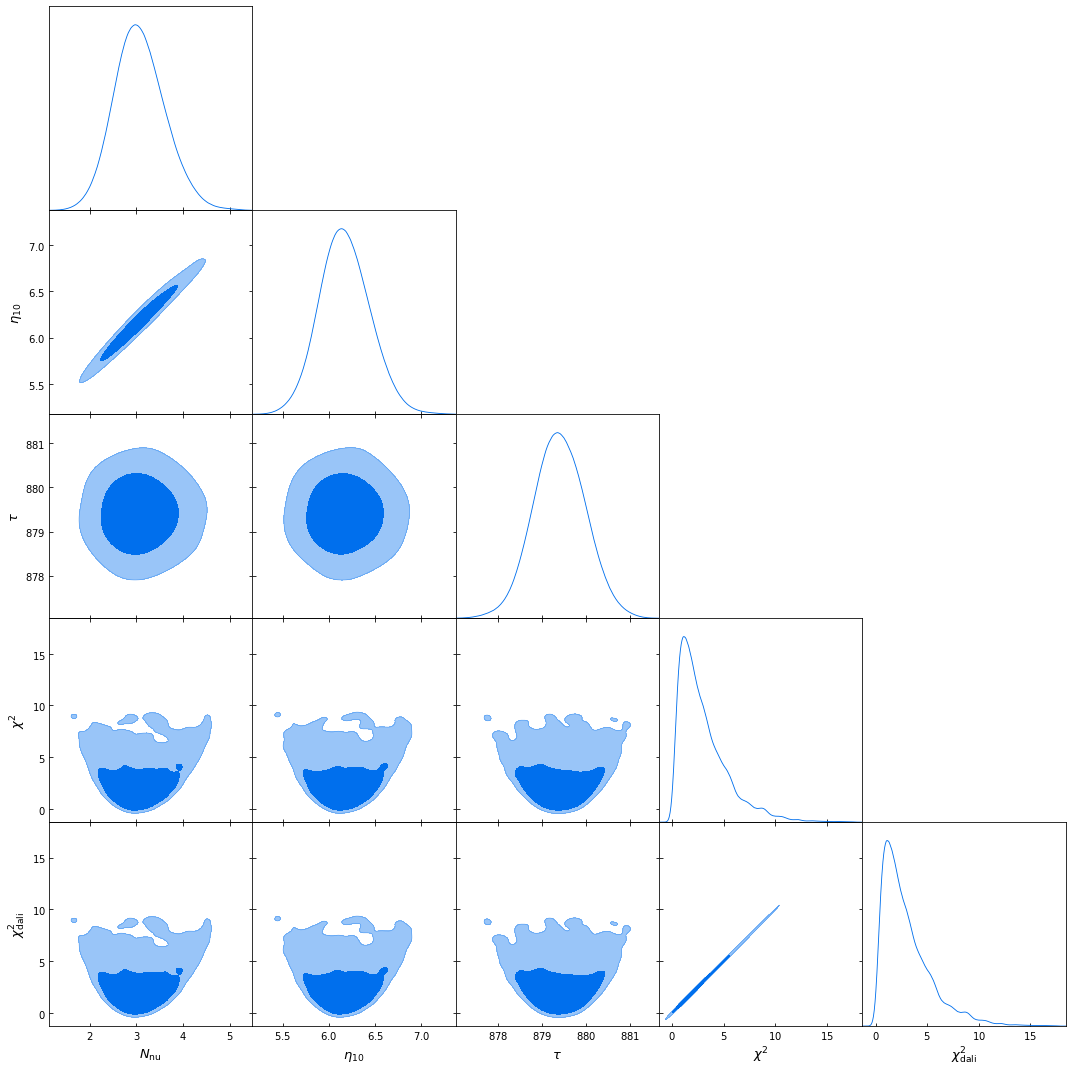

In [5]:
gdplot.triangle_plot(gdsDefault, filled=True)

In [6]:
import copy

updatedDali, samplerDali = run(get_model(use_dali=True))
gdsDali = MCSamplesFromCobaya(updatedDali, samplerDali.products()["sample"], name_tag='Dali')

updatedFisher, samplerFisher = run(get_model(use_dali=False))
gdsFisher = MCSamplesFromCobaya(updatedFisher, samplerFisher.products()["sample"], name_tag='Fisher')

[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {dali: 17000.0}
[mcmc] Covariance matrix loaded for params ['N_nu', 'eta10', 'tau']
[mcmc] All parameters' covariance loaded from given covmat.
[mcmc] Initial point: N_nu:3, eta10:6.13832, tau:879.4
[mcmc] Sampling!
[mcmc] Progress @ 2022-02-16 10:09:24 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.323
[mcmc]  - Convergence of means: R-1 = 0.222601 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.358
[mcmc]  - Convergence of means: R-1 = 0.507732 after 192 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 360 samples accepted.
[mcmc]  - Acceptance rate: 0.387
[mcmc]  - Convergence of means: R-

[root] *WARNING* Parameters are 100% correlated: chi2, chi2__dali


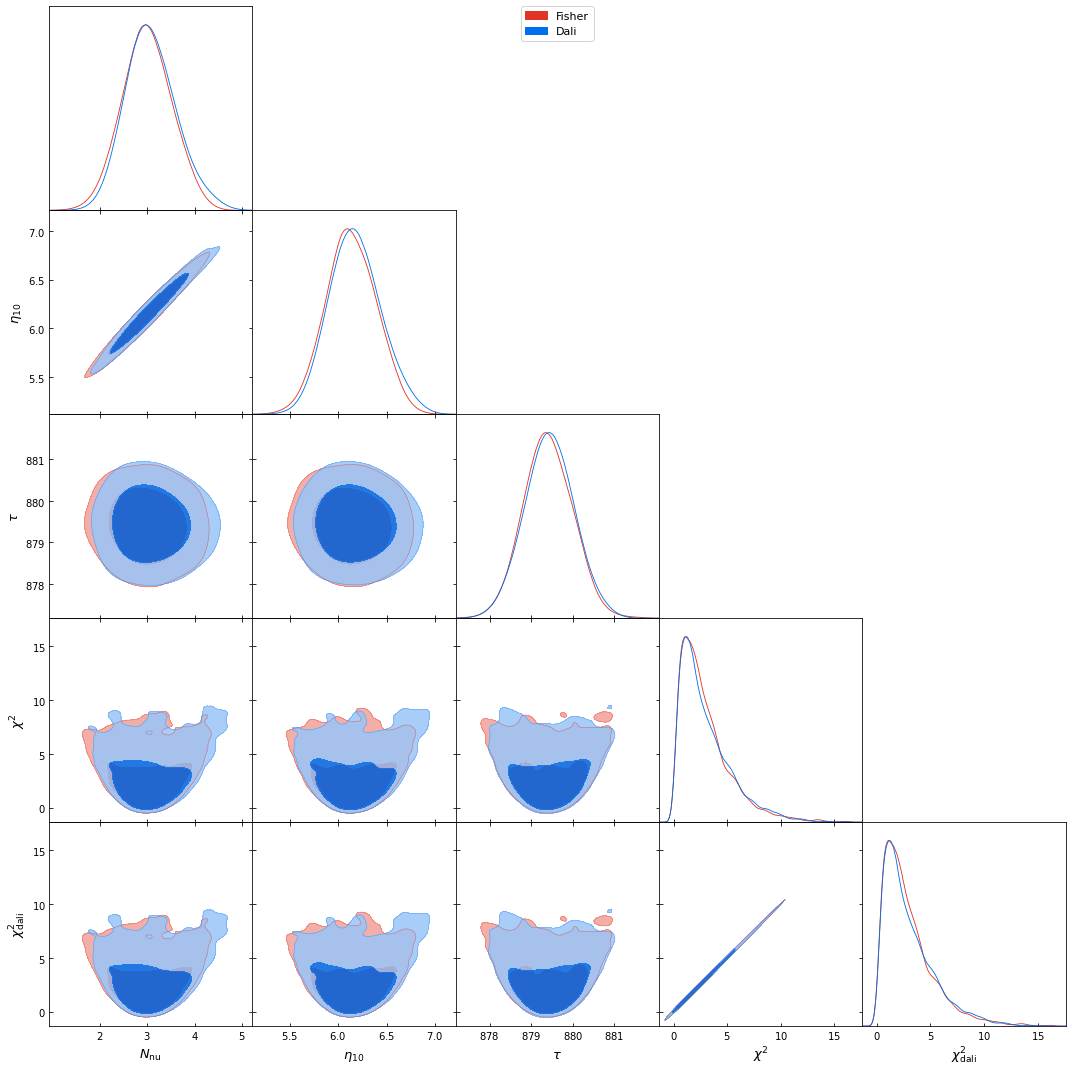

In [7]:
gdplot.triangle_plot([gdsFisher, gdsDali], filled=True)
# gdplot.triangle_plot(gdsDali, filled=True)
# gdplot.triangle_plot(gdsFisher, filled=True)

In [8]:
aVar = np.diag(defaultCov)
fVar = gdsFisher.getVars()[:-2]
dVar = gdsDali.getVars()[:-2]

print("dali - fisher:", dVar - fVar)
print("(dali - fisher)/fisher:", (dVar - fVar)/fVar)
print("aVar - fVar", aVar - fVar) 
print("(aVar - fVar)/fVar:", (aVar - fVar)/fVar)

dali - fisher: [0.01588466 0.00400885 0.00365119]
(dali - fisher)/fisher: [0.05576877 0.05752831 0.010138  ]
aVar - fVar [-0.00080087  0.00115817 -0.00014876]
(aVar - fVar)/fVar: [-0.00281174  0.01662016 -0.00041306]


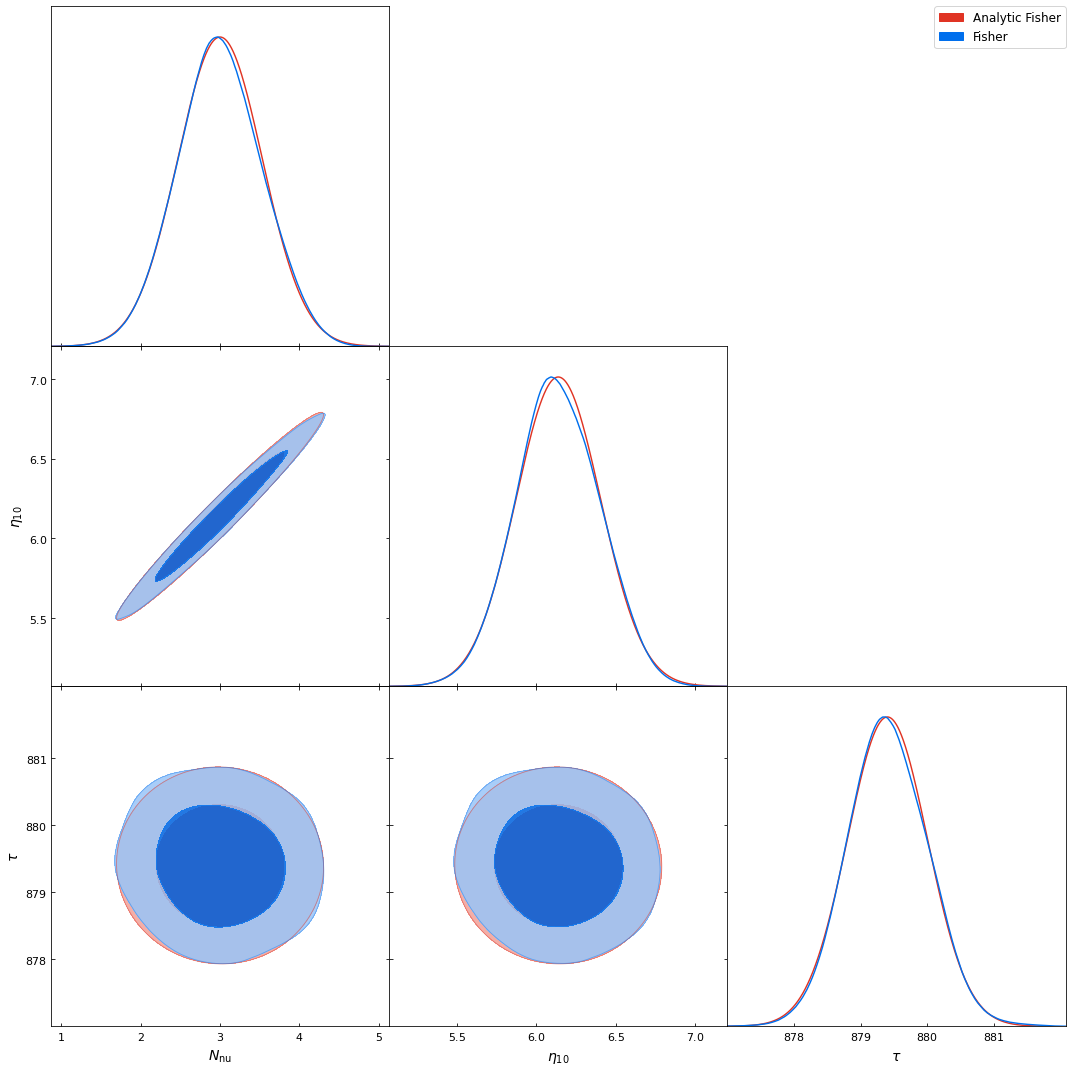

In [9]:
from getdist.gaussian_mixtures import GaussianND
gauss=GaussianND(list(defaultFid.values()), defaultCov, names=list(gdsFisher.getParamNames().list())[:-2], labels=list(gdsFisher.getParamNames().labels())[:-2], label='Analytic Fisher')
gdplot.triangle_plot([gauss, gdsFisher],filled=True)

In [10]:
sample_data = []
for width in range(3, 11, 1):
    m = get_model(prior_width=width)
    uf, sf = run(m)
    sample_data.append(MCSamplesFromCobaya(uf, sf.products()['sample'], name_tag='Dali - Width: %s'%width))

[mcmc] Getting initial point... (this may take a few seconds)
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {dali: 17000.0}
[mcmc] Covariance matrix loaded for params ['N_nu', 'eta10', 'tau']
[mcmc] All parameters' covariance loaded from given covmat.
[mcmc] Initial point: N_nu:3, eta10:6.13832, tau:879.4
[mcmc] Sampling!
[mcmc] Progress @ 2022-02-16 10:09:51 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.369
[mcmc]  - Convergence of means: R-1 = 1.365385 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.407
[mcmc]  - Convergence of means: R-1 = 0.713178 after 192 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 360 samples accepted.
[mcmc]  - Acceptance rate: 0.389
[mcmc]  - Convergence of means: R-

[root] *WARNING* Parameters are 100% correlated: chi2, chi2__dali


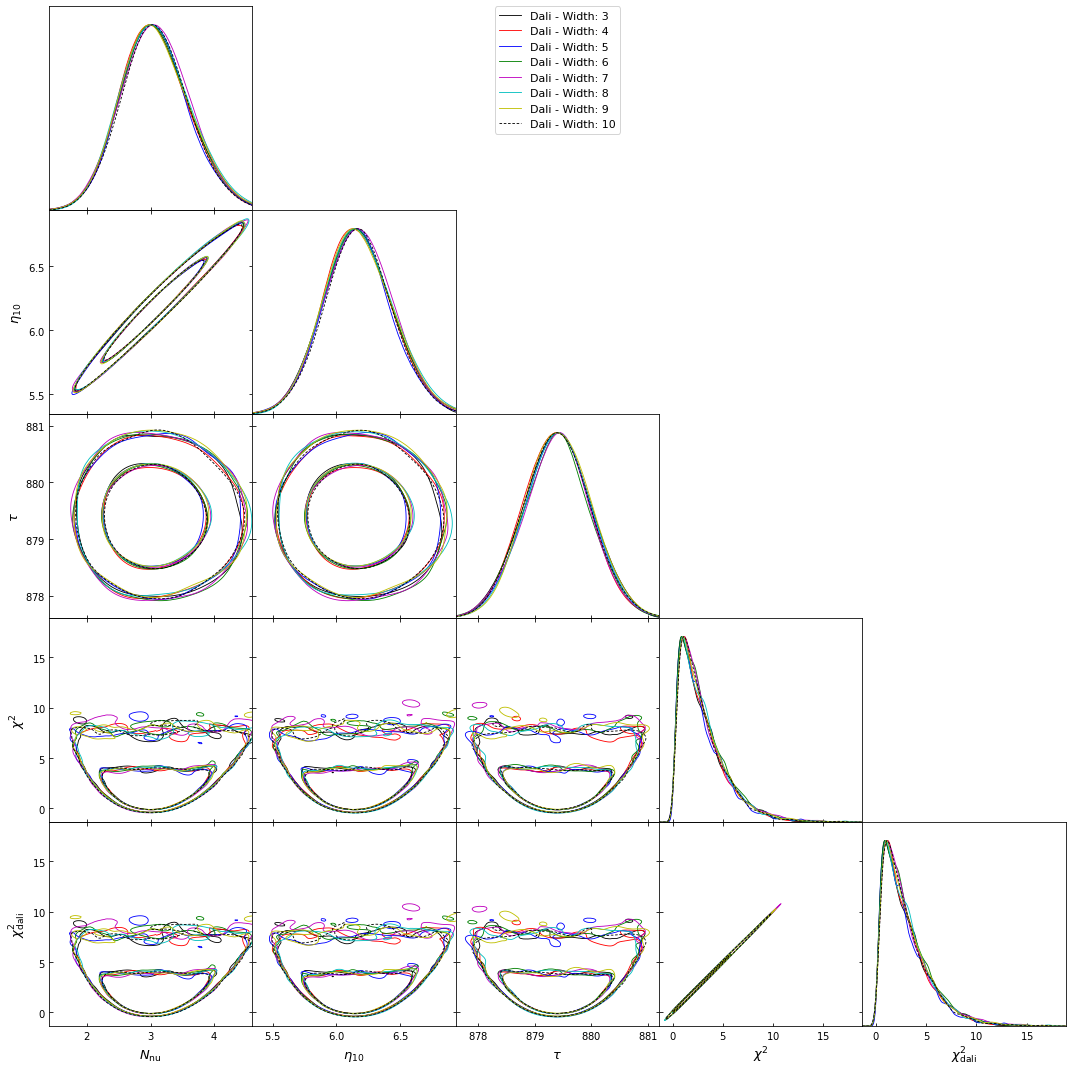

In [11]:
gdplot.triangle_plot(sample_data, filled=False)
# for v in sample_data: gdplot.triangle_plot(v, filled=True)